#### Importing libraries

In [66]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from tqdm import tqdm_notebook
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
import cv2

import atari roms:

In [96]:
!python -m atari_py.import_roms ROMS

copying breakout.bin from ROMS\Breakout - Breakaway IV (Paddle) (1978) (Atari, Brad Stewart - Sears) (CX2622 - 6-99813, 49-75107) ~.bin to C:\Users\cheng\Anaconda3\lib\site-packages\atari_py\atari_roms\breakout.bin
copying enduro.bin from ROMS\Enduro (1983) (Activision, Larry Miller) (AX-026, AX-026-04) ~.bin to C:\Users\cheng\Anaconda3\lib\site-packages\atari_py\atari_roms\enduro.bin
copying pong.bin from ROMS\pong.bin to C:\Users\cheng\Anaconda3\lib\site-packages\atari_py\atari_roms\pong.bin
copying tennis.bin from ROMS\Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to C:\Users\cheng\Anaconda3\lib\site-packages\atari_py\atari_roms\tennis.bin


#### Setup

In [97]:
#Initialize environment. v4 means no action repeat
env = gym.make('PongNoFrameskip-v4')

#wraps env with these preprocessing options:
#values will be scaled at training time to save memory
"""Atari 2600 preprocessings. 
    This class follows the guidelines in 
    Machado et al. (2018), "Revisiting the Arcade Learning Environment: 
    Evaluation Protocols and Open Problems for General Agents".
    Specifically:
    * NoopReset: obtain initial state by taking random number of no-ops on reset. 
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost: turned off by default. Not recommended by Machado et al. (2018).
    * Resize to a square image: 84x84 by default
    * Grayscale observation: optional
    * Scale observation: optional"""
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, 
                                      screen_size=84, terminal_on_life_loss=False, 
                                      grayscale_obs=True, grayscale_newaxis=False, scale_obs=False)

env = gym.wrappers.FrameStack(env, 4)


In [98]:
#actions in this environment
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [114]:
#number of frames to run
NUM_FRAMES = 200000

#number of episodes to run
NUM_EPISODES = 5000

#max iterations per run
MAX_ITERATIONS = 1000000

#epsilon for choosing action
eps = 1

#minimum eps
eps_min = 0.1

#eps linear decay for first 10% of run
eps_linear_decay = (eps-eps_min)/(MAX_ITERATIONS/10)

#discount factor for future utility
discount_factor = 0.99

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY = 1000000

#initial population of memory using random policy
INIT_MEMORY = 50000

#update interval to use target network
TARGET_C = 10000

### Random Strategy:

In [100]:
#keep scores
scores = []
frames = 0

#iterate through 10 playthroughs
for _ in tqdm_notebook(range(10)):
    
    #reset env
    env.reset()
    done = False
    score = 0
    
    #while game is not over
    while not done:
        #render env
        env.render()
        frames += 1
        
        #execute random action
        _, reward, done, _ = env.step(env.action_space.sample())
        
        #track score
        score += reward
        
    #append to score list
    scores.append(score)
env.close()

### Learning with image input v1:

In [5]:
def epsilon_greedy(eps, model, env, state):
    ''' Returns an action using epsilon greedy strategy
    Args:
    - eps (int): chance for random action
    - model (Model): Keras model used to choose best action
    - env (EnvSpec): Gym environment
    
    Returns:
    - (int): index of best action
    '''
    #exploration
    if eps < np.random.random():
        
        #random action
        return env.action_space.sample()
    
    #exploitation
    else:
        
        #get best action for current state
        q_vals = model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_vals)

In [143]:
def experience_replay(memory, model, target_model, discount_factor, batch_size):
    ''' Fits the model with minibatch of states from memory
    Args:
    - memory (Array): array of environment transitions
    - model (Model): Keras model to be fit
    - target_model (Model): Keras model to get target Q val
    - discount_factor (float): discount factor for future utility
    - batch_size (int): size of minibatch
    
    Returns: None
    '''
    
    #if memory is less than batch size, return nothing
    if len(memory) < batch_size:
        return
    else:
        states = []
        targets = []
        
        #sample a batch
        minibatch = random.sample(memory, batch_size)
        
        #iterate through bastch
        for state, action, reward, new_state, done in minibatch:
            target = reward
            
            #if game not over, target q val includes discounted future utility
            #we use a cloned model to predict here for stability. Model is changed every C frames
            if not done:
                target = reward + discount_factor * np.max(target_model.predict(np.expand_dims(new_state, axis=0)))
            
            #get current actions vector
            target_vector = model.predict(np.expand_dims(state, axis=0))[0]
            
            #update current action q val with target q val
            target_vector[action] = target
            
            #add to states
            states.append(state)
            
            #add to targets
            targets.append(target_vector)
        
        #scale states to be [0,1]. We only scale before fitting cuz storing uint8 is cheaper
        states = [np.array(state)/255 for state in states]
        print('States:')
        print(states)
        print('Targets:')
        print(targets)
        
        #fit model with states and target action vectors
        model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
        

In [134]:
#Credit to: https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c
def copy_model(model):
    '''Returns a copy of a keras model.
    Args:
    - model (Model): Keras model to be copied
    
    Returns:
    - (Model): copy of Keras model
    '''
    print('copied')
    model.save('tmp_model')
    return keras.models.load_model('tmp_model', custom_objects={'tf': tf})

In [63]:
def ncwh_to_nwhc(tensor):
    '''Converts tensor from NCWH to NWHC
    Args:
    - tensor (4D Array): NCWH tensor
    
    Returns:
    - (4D Array): tensor in NWHC format
    '''
    return tf.transpose(tensor, [0, 2, 3, 1])

In [105]:
#I use lambda layer so I can convert NCWH to NWHC since CPU training doesn't support NCWH
model = Sequential(
    [
        Lambda(ncwh_to_nwhc, output_shape=(84, 84, 4), input_shape=(4, 84, 84)),
        Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu", input_shape=(4, 84, 84)),
        Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(env.action_space.n, activation="linear"),
    ]
)

model.compile(loss="mse", optimizer="RMSprop")
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_16 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               663808    
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 1542      
Total params: 677,686
Trainable params: 677,686
Non-trainable params: 0
_______________________________________________

In [120]:
#initial target model
target_model = copy_model(model)

In [144]:
#Prefill memory with INIT_MEMORY frames

#init scores
scores = []

#init memory using deque to only store MAX_MEMORY
memory = deque(maxlen=MAX_MEMORY)

#progress bar
pbar = tqdm_notebook(total=INIT_MEMORY)

#playthrough game until memory is prefilled
while len(memory) < INIT_MEMORY:
    
    #reset env
    state = env.reset()

    done = False
    
    #playthrough
    while not done:
        
        #random action
        action = env.action_space.sample()
        
        #execute action
        new_state, reward, done, info = env.step(action)
        
        #add transition to memory
        memory.append([state, action, reward, new_state, done])
        
        #progress bar
        pbar.update(1)
        
        #update state
        state = new_state
        
#close progress bar
pbar.close()

KeyboardInterrupt: 

In [145]:
total_frames = 0
num_updates = 0

pbar = tqdm_notebook(total=NUM_FRAMES)

#run frames
while total_frames < NUM_FRAMES:
#for _ in tqdm_notebook(range(NUM_EPISODES)):
        
    state = env.reset()
    done = False
    score = 0
    frames = 0
    
    #playing through this round
    for frame in range(MAX_ITERATIONS):
        
        frames += 1
        
        #epsilon greedy choose action
        action = epsilon_greedy(eps, model, env, state)
        
        #decay epsilon
        eps -= eps_linear_decay
        eps = max(eps, eps_min)
        
        #execute action
        new_state, reward, done, info = env.step(action)
        
        #track score
        score += reward
        
        #memorize
        memory.append([state, action, reward, new_state, done])
        
        #exp replay
        experience_replay(memory, model, model, discount_factor, batch_size)
        
        #clone target network every C frames
        num_updates += batch_size
        
        if num_updates > TARGET_C:
            num_updates = 0
            target_model = copy_model(model)
            
        
        #update state
        state = new_state
        
        pbar.update(1)
        
        if done:
            break
    
    scores.append(score)
    total_frames += frames
    
pbar.close()
        

States:
[array([[[0.20392157, 0.20392157, 0.20392157, ..., 0.34117647,
         0.34117647, 0.34117647],
        [0.34117647, 0.34117647, 0.34117647, ..., 0.34117647,
         0.34117647, 0.34117647],
        [0.34117647, 0.34117647, 0.34117647, ..., 0.34117647,
         0.34117647, 0.34117647],
        ...,
        [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.9254902 ,
         0.9254902 , 0.9254902 ],
        [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.9254902 ,
         0.9254902 , 0.9254902 ],
        [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.9254902 ,
         0.9254902 , 0.9254902 ]],

       [[0.20392157, 0.20392157, 0.20392157, ..., 0.34117647,
         0.34117647, 0.34117647],
        [0.34117647, 0.34117647, 0.34117647, ..., 0.34117647,
         0.34117647, 0.34117647],
        [0.34117647, 0.34117647, 0.34117647, ..., 0.34117647,
         0.34117647, 0.34117647],
        ...,
        [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.9254902 ,
         0.9254902 , 0.9254902 ],
   

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01135373, -0.01152823, -0.0104892 , -0.0067165 , -0.00401162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.00401162, -0.0067165 , -0.01158162,
       -0.00405214], dtype=float32), array([-0.00401162, -0.01152823, -0.0104892 , -0.0067165 , -0.01158162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.0104892 , -0.0067165 , -0.01158162,
       -0.00401162], dtype=float32), array([-0.01135373, -0.01152823, -0.00401162, -0.0067165 , -0.01158162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.00401162, -0.0067165 , -0.01158162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.0104892 , -0.0067165 , -0.00401162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.0104892 , -0.0067165 , -0.00401162,
       -0.00405214], dtype=float32), array([-0.01135373, -0.01152823, -0.0104892 , -0.0067165 , -0.01158162,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01129817, -0.01147382, -0.01241323, -0.00400962, -0.01144316,
       -0.00405012], dtype=float32), array([-0.00400962, -0.01147382, -0.01241323, -0.00668043, -0.01144316,
       -0.00405012], dtype=float32), array([-0.01129817, -0.00400962, -0.01241323, -0.00668043, -0.01144316,
       -0.00405012], dtype=float32), array([-0.00400962, -0.01147382, -0.01241323, -0.00668043, -0.01144316,
       -0.00405012], dtype=float32), array([-0.01129817, -0.00400962, -0.01241323, -0.00668043, -0.01144316,
       -0.00405012], dtype=float32), array([-0.01129817, -0.01147382, -0.01241323, -0.00400962, -0.01144316,
       -0.00405012], dtype=float32), array([-0.01129817, -0.01147382, -0.01241323, -0.00400962, -0.01144316,
       -0.00405012], dtype=float32), array([-0.01129817, -0.01147382, -0.01241323, -0.00668043, -0.00400962,
       -0.00405012], dtype=float32), array([-0.01129817, -0.01147382, -0.01241323, -0.00668043, -0.00400962,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01124005, -0.0040092 , -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.0040092 , -0.01139412, -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.0040092 , -0.01139412, -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.0040092 , -0.01139412, -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.01124005, -0.01139412, -0.01234326, -0.00660538, -0.0040092 ,
       -0.0040497 ], dtype=float32), array([-0.01124005, -0.0040092 , -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.01124005, -0.0040092 , -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.0040092 , -0.01139412, -0.01234326, -0.00660538, -0.01124292,
       -0.0040497 ], dtype=float32), array([-0.01124005, -0.01139412, -0.01234326, -0.0040092 , -0.01124292,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01113375, -0.00400854, -0.01227013, -0.00655732, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.00400854, -0.01227013, -0.00655732, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.01227013, -0.00400854, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.00400854, -0.00655732, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.01227013, -0.00400854, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.00400854, -0.00655732, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.01227013, -0.00655732, -0.00400854,
       -0.00404903], dtype=float32), array([-0.00400854, -0.01127546, -0.01227013, -0.00655732, -0.01115493,
       -0.00404903], dtype=float32), array([-0.01113375, -0.01127546, -0.00400854, -0.00655732, -0.01115493,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01111797, -0.01118933, -0.0040076 , -0.00899909, -0.01100238,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0140426 , -0.00899909, -0.01100238,
       -0.0040076 ], dtype=float32), array([-0.01111797, -0.0040076 , -0.0140426 , -0.00899909, -0.01100238,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0140426 , -0.00899909, -0.0040076 ,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0140426 , -0.00899909, -0.0040076 ,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0040076 , -0.00899909, -0.01100238,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0140426 , -0.00899909, -0.0040076 ,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0140426 , -0.00899909, -0.0040076 ,
       -0.00404808], dtype=float32), array([-0.01111797, -0.01118933, -0.0040076 , -0.00899909, -0.01100238,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01105162, -0.01270936, -0.00400687, -0.00894691, -0.01075136,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00400687, -0.01075136,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00894691, -0.00400687,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00400687, -0.01075136,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00894691, -0.01075136,
       -0.00400687], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00894691, -0.01075136,
       -0.00400687], dtype=float32), array([-0.01105162, -0.00400687, -0.01386061, -0.00894691, -0.01075136,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.00400687, -0.00894691, -0.01075136,
       -0.00404734], dtype=float32), array([-0.01105162, -0.01270936, -0.01386061, -0.00894691, -0.00400687,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01099965, -0.0126376 , -0.01375602, -0.00882452, -0.0105921 ,
       -0.00400557], dtype=float32), array([-0.01099965, -0.0126376 , -0.01375602, -0.00882452, -0.00400557,
       -0.00404603], dtype=float32), array([-0.01099965, -0.0126376 , -0.00400557, -0.00882452, -0.0105921 ,
       -0.00404603], dtype=float32), array([-0.01099965, -0.0126376 , -0.01375602, -0.00400557, -0.0105921 ,
       -0.00404603], dtype=float32), array([-0.01099965, -0.0126376 , -0.01375602, -0.00882452, -0.00400557,
       -0.00404603], dtype=float32), array([-0.00400557, -0.0126376 , -0.01375602, -0.00882452, -0.0105921 ,
       -0.00404603], dtype=float32), array([-0.01099965, -0.0126376 , -0.01375602, -0.00882452, -0.0105921 ,
       -1.0040056 ], dtype=float32), array([-0.01099965, -0.00400557, -0.01375602, -0.00882452, -0.0105921 ,
       -0.00404603], dtype=float32), array([-0.01099965, -0.00400557, -0.01375602, -0.00882452, -0.0105921 ,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.00684603, -0.0124877 , -0.01366877, -0.0087686 , -0.01039575,
       -0.00691519], dtype=float32), array([-0.01092716, -0.0124877 , -0.01366877, -0.00684603, -0.01039575,
       -0.00691519], dtype=float32), array([-0.01092716, -0.00684603, -0.01366877, -0.0087686 , -0.01039575,
       -0.00691519], dtype=float32), array([-0.01092716, -0.00684603, -0.01366877, -0.0087686 , -0.01039575,
       -0.00691519], dtype=float32), array([-0.00684603, -0.0124877 , -0.01366877, -0.0087686 , -0.01039575,
       -0.00691519], dtype=float32), array([-0.01092716, -0.0124877 , -0.01366877, -0.0087686 , -0.01039575,
       -0.00684603], dtype=float32), array([-0.01092716, -0.0124877 , -0.01366877, -0.0087686 , -0.01039575,
       -0.00684603], dtype=float32), array([-0.01092716, -0.0124877 , -0.00684603, -0.0087686 , -0.01039575,
       -0.00691519], dtype=float32), array([-0.01092716, -0.0124877 , -0.01366877, -0.00684603, -0.01039575,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01086029, -0.01242576, -0.0155082 , -0.0087392 , -0.01033999,
       -1.        ], dtype=float32), array([-0.01086029, -0.01242576, -0.00865181, -0.0087392 , -0.01033999,
       -0.00910056], dtype=float32), array([-0.01086029, -0.01242576, -0.0155082 , -0.00865181, -0.01033999,
       -0.00910056], dtype=float32), array([-0.00865181, -0.01242576, -0.0155082 , -0.0087392 , -0.01033999,
       -0.00910056], dtype=float32), array([-0.01086029, -0.01242576, -0.00865181, -0.0087392 , -0.01033999,
       -0.00910056], dtype=float32), array([-0.01086029, -0.01242576, -0.0155082 , -0.0087392 , -0.00865181,
       -0.00910056], dtype=float32), array([-0.01086029, -0.01242576, -0.0155082 , -0.0087392 , -0.00865181,
       -0.00910056], dtype=float32), array([-0.01086029, -0.01242576, -0.0155082 , -0.0087392 , -0.00865181,
       -0.00910056], dtype=float32), array([-0.01086029, -0.00865181, -0.0155082 , -0.0087392 , -0.01033999,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.0108158 , -0.0123748 , -0.01545277, -0.00873808, -0.01028409,
       -0.0086507 ], dtype=float32), array([-0.0108158 , -0.0123748 , -0.01545277, -0.00873808, -0.01028409,
       -0.0086507 ], dtype=float32), array([-0.0108158 , -0.0123748 , -0.01545277, -0.0086507 , -0.01028409,
       -0.01095022], dtype=float32), array([-0.0108158 , -0.0123748 , -0.0086507 , -0.00873808, -0.01028409,
       -0.01095022], dtype=float32), array([-0.0108158 , -0.0123748 , -0.01545277, -0.00873808, -0.01028409,
       -0.0086507 ], dtype=float32), array([-0.0086507 , -0.0123748 , -0.01545277, -0.00873808, -0.01028409,
       -0.01095022], dtype=float32), array([-0.0108158 , -0.0086507 , -0.01545277, -0.00873808, -0.01028409,
       -0.01095022], dtype=float32), array([-0.0108158 , -0.0123748 , -0.01545277, -0.00873808, -0.01028409,
       -0.0086507 ], dtype=float32), array([-0.0108158 , -0.0123748 , -0.0086507 , -0.00873808, -0.01028409,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01077639, -0.01232938, -0.01538032, -0.01105244, -0.01017185,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01017185, -0.01105244, -0.01027459,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01017185, -0.01105244, -0.01027459,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01538032, -0.01105244, -0.01027459,
       -0.01017185], dtype=float32), array([-0.01077639, -0.01232938, -0.01538032, -0.01105244, -0.01027459,
       -0.01017185], dtype=float32), array([-0.01077639, -0.01232938, -0.01017185, -0.01105244, -0.01027459,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01538032, -0.01017185, -0.01027459,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01538032, -0.01017185, -0.01027459,
       -0.01090945], dtype=float32), array([-0.01077639, -0.01232938, -0.01538032, -0.01105244, -0.01027459,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01076865, -0.01231089, -0.01531017, -0.01104169, -0.01308466,
       -0.01066097], dtype=float32), array([-0.01076865, -0.01231089, -0.01531017, -0.01104169, -0.01066097,
       -0.01090026], dtype=float32), array([-0.01076865, -0.01231089, -0.01531017, -0.01104169, -0.01066097,
       -0.01090026], dtype=float32), array([-0.01076865, -0.01066097, -0.01531017, -0.01104169, -0.01308466,
       -0.01090026], dtype=float32), array([-0.01076865, -0.01231089, -0.01066097, -0.01104169, -0.01308466,
       -0.01090026], dtype=float32), array([-0.01076865, -0.01231089, -0.01531017, -0.01104169, -0.01308466,
       -0.01066097], dtype=float32), array([-0.01076865, -0.01231089, -0.01531017, -0.01066097, -0.01308466,
       -0.01090026], dtype=float32), array([-0.01066097, -0.01231089, -0.01531017, -0.01104169, -0.01308466,
       -0.01090026], dtype=float32), array([-0.01076865, -0.01231089, -0.01531017, -0.01104169, -0.01308466,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01076793, -0.01066025, -0.01525517, -0.01303457, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01066025, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01066025, -0.01303457, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01066025, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01303457, -0.01066025,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01066025, -0.01303457, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01066025, -0.01303438,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01303457, -0.01066025,
       -0.01089502], dtype=float32), array([-0.01076793, -0.01230343, -0.01525517, -0.01303457, -0.01066025,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01076793, -0.01227996, -0.01516353, -0.01066025, -0.01299729,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01298959, -0.01299729,
       -0.01066025], dtype=float32), array([-0.01076793, -0.01227996, -0.01066025, -0.01298959, -0.01299729,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01066025, -0.01299729,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01298959, -0.01299729,
       -0.01066025], dtype=float32), array([-0.01076793, -0.01227996, -0.01066025, -0.01298959, -0.01299729,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01298959, -0.01066025,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01298959, -0.01066025,
       -0.01089285], dtype=float32), array([-0.01076793, -0.01227996, -0.01516353, -0.01298959, -0.01066025,
       -0

         0.9254902 , 0.9254902 ]]])]
Targets:
[array([-0.01076591, -0.0122637 , -0.01506891, -0.01296374, -0.01065825,
       -0.01089002], dtype=float32), array([-0.01065825, -0.0122637 , -0.01506891, -0.01296374, -0.01295882,
       -0.01089002], dtype=float32), array([-0.01076591, -0.0122637 , -0.01065825, -0.01296374, -0.01295882,
       -0.01089002], dtype=float32), array([-0.01076591, -0.01065825, -0.01506891, -0.01296374, -0.01295882,
       -0.01089002], dtype=float32), array([-0.01065825, -0.0122637 , -0.01506891, -0.01296374, -0.01295882,
       -0.01089002], dtype=float32), array([-0.01076591, -0.0122637 , -0.01506891, -0.01065825, -0.01295882,
       -0.01089002], dtype=float32), array([-0.01076591, -0.0122637 , -0.01506891, -0.01296374, -0.01065825,
       -0.01089002], dtype=float32), array([-0.01076591, -0.0122637 , -0.01506891, -0.01296374, -0.01065825,
       -0.01089002], dtype=float32), array([-0.01065825, -0.0122637 , -0.01506891, -0.01296374, -0.01295882,
       -0

KeyboardInterrupt: 

### Learning with RAM input:

#### Plotting scores:

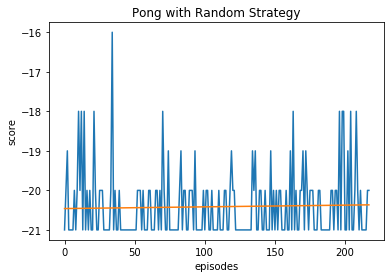

In [129]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong with Random Strategy')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Trying policy:


In [130]:
done = False
score = 0
state = env.reset()

while not done:
    env.render()
    action = np.argmax(model.predict(np.expand_dims(state, axis=0)))
    new_state, reward, done, info = env.step(action)
    state = new_state
env.close()